In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , top_biz_pred
                        , surprise_validate
                        , NMF_Mat
                       )

In [4]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [5]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [6]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [7]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [8]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [9]:
user_biz_collab_mat.shape

(140940, 7081)

### SVD

In [10]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### Precictions

In [11]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort'])

In [12]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:5]

3360      Butters Pancakes & Café
312378                 Wildflower
600627               Flower Child
624904               Viet Kitchen
744479                 Wildflower
Name: biz_name, dtype: object

### Validation

In [13]:
from surprise import (SVD
                      , SVDpp
                      , SlopeOne
                      , NMF
                      , NormalPredictor
                      , KNNBaseline
                      , KNNBasic
                      , KNNWithMeans
                      , KNNWithZScore
                      , BaselineOnly
                      , CoClustering)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

In [14]:
data = user_rev_biz[['user_id'
                    , 'business_id'
                    , 'average_stars']].loc[user_rev_biz.city == 'Scottsdale']


In [15]:
type(data.average_stars.iat[0])

numpy.float64

In [16]:
data.shape

(329826, 3)

In [17]:
len(data.user_id.unique())

140940

In [18]:
len(data.business_id.unique())

7081

In [19]:
reader = Reader()
data = Dataset.load_from_df(data, reader)

In [20]:
trainset, testset = train_test_split(data, test_size = 0.25)

In [21]:
algo = SVD()
algo.fit(trainset)

In [22]:
predictions = algo.test(testset)

In [23]:
accuracy.rmse(predictions)

RMSE: 0.7076


0.7075752860123586

In [24]:
svd_results = cross_validate(SVD(), data, cv = 5)

In [25]:
svd_results['test_rmse']

array([0.69640875, 0.70039832, 0.70292265, 0.69248905, 0.70347494])

In [26]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD()
                  , NMF()
                  , NormalPredictor()
                  , CoClustering()
                  , BaselineOnly()
                 ]:
    # Perform cross validation
    results = cross_validate(algorithm
                             , data
                             , measures=['RMSE']
                             , cv=5
                             , verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7002  0.6912  0.7017  0.7048  0.6994  0.6994  0.0045  
Fit time          11.93   12.57   12.29   12.45   12.98   12.44   0.34    
Test time         0.38    0.41    0.80    0.85    0.46    0.58    0.20    
Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6420  0.6401  0.6410  0.6355  0.6365  0.6390  0.0026  
Fit time          22.33   20.29   21.99   19.74   19.80   20.83   1.11    
Test time         0.34    0.39    0.33    0.33    0.32    0.34    0.02    
Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1024  1.0983  1.1024  1.1052  1.1037  1.1024  0.0023  
Fit time          0.40    0.54    0.55    0.56    0.56    0.52    0.06    
Test time       

,test_rmse,fit_time,test_time
Algorithm,,,
NMF,0.639001,20.833203,0.343200
SVD,0.699430,12.442564,0.578191
BaselineOnly,0.718083,1.817427,0.454606
CoClustering,0.800819,14.599660,0.463714
NormalPredictor,1.102403,0.522243,0.378972


### NMF

In [27]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [28]:
NMF_results['test_rmse']

array([0.64961969, 0.63993138, 0.63813608, 0.64281274, 0.62892098])

In [29]:
from sklearn.decomposition import NMF

In [30]:
model_nmf = NMF(n_components = 40
               , init = 'random'
               , random_state = 0)

In [31]:
m = model_nmf.fit_transform(user_biz_collab_mat)

In [32]:
m.shape

(140940, 40)

In [33]:
h = model_nmf.components_

In [34]:
h.shape

(40, 7081)

In [35]:
nmf_mat = m @ h

In [36]:
nmf_mat.shape

(140940, 7081)

In [37]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'North Italia',
  "Portillo's Hot Dogs",
  "Mastro's Ocean Club",
  'Sweet Republic'])

In [38]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Neural Network Recommender



In [124]:
# https://www.youtube.com/watch?v=4vwNkHFuZBk

In [92]:
nmf_mat.shape

(140940, 7081)

In [93]:
user_rev_biz_scott = user_rev_biz[['user_id'
                                   , 'user_name'
                                   , 'business_id'
                                   , 'biz_name'
                                   , 'average_stars']].loc[user_rev_biz.city == 'Scottsdale']

In [94]:
user_id_list = list(user_rev_biz_scott.user_id.value_counts().index)

In [95]:
user_id_dict = {y: x for (x, y) in enumerate(user_id_list)}

In [96]:
#user_id_dict

In [97]:
user_rev_biz_scott['user_num'] = user_rev_biz_scott.user_id.map(user_id_dict)

In [98]:
# user_name_list = []
# for i in range(len(user_id_dict)):
#     user_name_list.append(user_rev_biz_scott.user_name.loc[user_rev_biz_scott.user_id==user_id_dict[i]].iat[0])

In [99]:
biz_id_list = list(user_rev_biz_scott.business_id.value_counts().index)

In [100]:
biz_id_dict = {y: x for (x, y) in enumerate(biz_id_list)}

In [101]:
# biz_id_dict

In [102]:
# biz_name_list = []
# for i in range(len(biz_id_dict)):
#     biz_name_list.append(user_rev_biz_scott.biz_name.loc[user_rev_biz_scott.business_id==biz_id_dict[i]].iat[0])

In [103]:
user_rev_biz_scott['biz_num'] = user_rev_biz_scott.business_id.map(biz_id_dict)

In [104]:
user_rev_biz_scott.head()

,user_id,user_name,business_id,biz_name,average_stars,user_num,biz_num
614,4XChL029mKr5hydo79Ljxg,Jenna,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman,3.63,1906,2292
615,O7ojHP59iSi32uhEDUR44A,Jasmine,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman,3.65,99,2292
616,HfmcMLJb3HMOen7VrLk0bw,Kim,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman,4.79,2836,2292
617,BmipmKVTx37gpfPzK7eU4A,Kirstin,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman,3.95,617,2292
618,_ILD1nTTCBjp0FdG1j2aNw,Colleen,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman,4.55,122238,2292


In [105]:
from sklearn.model_selection import train_test_split

In [132]:
X = user_rev_biz_scott[['user_num'
                        , 'user_name'
                        , 'biz_num'
                        , 'biz_name'
                        , 'average_stars'
                       ]]
y = user_rev_biz_scott.average_stars
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.25
                                                    , random_state=42)

In [133]:
n_users = user_rev_biz_scott.user_id.nunique()

In [134]:
n_users

140940

In [135]:
n_biz = user_rev_biz_scott.business_id.nunique()

In [136]:
n_biz

7081

In [137]:
n_factors = 10

In [181]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

In [206]:
biz_input = Input(shape=[1]
                 , name = 'Biz_Input')
biz_embedding = Embedding(n_biz
                         , 5
                         , name='Biz_Embed')(biz_input)
biz_vac = Flatten(name = 'Flatten_Biz')(biz_embedding)

user_input = Input(shape=[1]
                  , name = 'User_Input')
user_embedding = Embedding(n_users
                          , 5
                          , name = 'User_Embed')(user_input)
user_vac = Flatten(name = "Flatten_User")(user_embedding)

prod = Dot(name = 'Dot_Product'
          , axes = 1)([biz_vac, user_vac])
model = Model([user_input, biz_input]
             , prod)
model.compile(optimizer = 'adam'
             , loss = 'mse'
             , metrics = ['accuracy'])

In [207]:
import os

In [208]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [209]:
if os.path.exists('biz_model.h5'):
    model = load_model('biz_model.h5')
else:
    history = model.fit([X_train.user_num
                         , X_train.biz_num]
                         , y_train
                         , epochs=14
                         , verbose=True
                         , validation_data = ([X_test.user_num
                                               , X_test.biz_num]
                                               , y_test)
                         , callbacks = [TestCallback(([X_test.user_num
                                                       , X_test.biz_num]
                                                       , y_test))]
                       )

Train on 247369 samples, validate on 82457 samples
Epoch 1/14
247264/247369 [============================>.] - ETA: 0s - loss: 15.2728 - accuracy: 0.0000e+00
Testing loss: 14.42509171494818, acc: 0.0

247369/247369 [==============================] - 52s 212us/sample - loss: 15.2726 - accuracy: 0.0000e+00 - val_loss: 14.4251 - val_accuracy: 0.0000e+00
Epoch 2/14
247296/247369 [============================>.] - ETA: 0s - loss: 12.4123 - accuracy: 7.6831e-05
Testing loss: 11.22022095147786, acc: 0.00015765793796163052

247369/247369 [==============================] - 49s 197us/sample - loss: 12.4121 - accuracy: 7.6808e-05 - val_loss: 11.2202 - val_accuracy: 1.5766e-04
Epoch 3/14
247360/247369 [============================>.] - ETA: 0s - loss: 8.9370 - accuracy: 0.0025
Testing loss: 9.204005981426437, acc: 0.000751907064113766

247369/247369 [==============================] - 54s 220us/sample - loss: 8.9370 - accuracy: 0.0025 - val_loss: 9.2040 - val_accuracy: 7.5191e-04
Epoch 4/14
247136/

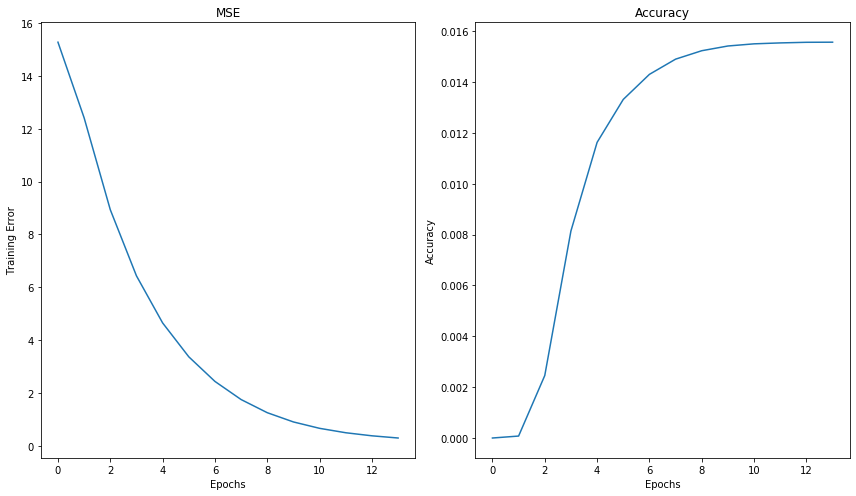

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Error')
ax[0].set_title('MSE')
    
ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy');

In [212]:
model.evaluate([X_test.user_num, X_test.biz_num]
               , y_test)

82457/82457 [==============================] - 2s 23us/sample - loss: 5.6618 - accuracy: 0.0017


[5.661788674036531, 0.0016978546]

In [213]:
n = 10 # number of predictions
predictions = model.predict([X_test.user_num.head(n)
                            , X_test.biz_num.head(n)]
                           )
pred_df = X_test[['user_name', 'biz_name', 'average_stars']].iloc[0:n]
pred_df['Prediction'] = predictions
pred_df

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,5.095905
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.839048
2675092,Ashley,Zoes Kitchen,4.11,4.783405
3141992,Dawn,Scottsdale Nails,4.70,4.871737
2063207,Shaila,Saints & Scissors Salon,4.71,0.281892
3693030,Shaya,Persian Room,4.06,3.876282
6037906,Marnie,Sir Grout Phoenix,3.75,0.111018
1878741,Chelsea,Houston's Restaurant,4.25,4.244737
4351605,Horace,Nekter Juice Bar,4.75,4.654537
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,3.539631


### Using Texts to Model Business to Business Similarity

In [67]:
user_rev_biz.fillna('', inplace = True)

In [68]:
user_rev_biz.isna().sum()

user_id               0
user_name             0
user_review_count     0
yelping_since         0
useful_user_sent      0
funny_user_sent       0
cool_user_sent        0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
review_id             0
business_id           0
stars_rev             0
useful_rev            0
funny_rev             0
cool_rev              0
rev_text              0
date                  0
biz_name              0
city                  0
biz_star              0
biz_review_count      0
attributes            0
categories            0
dtype: int64

In [69]:
# combine re_text and categories
def combine(rows):
    return rows['rev_text']+' '+rows['categories']

In [70]:
user_rev_biz['text'] = user_rev_biz.apply(combine
                                          , axis = 1)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

In [72]:
user_rev_biz_scott = user_rev_biz.loc[user_rev_biz.city == 'Scottsdale']

In [73]:
len(user_rev_biz_scott.user_id.value_counts())

140940

In [74]:
urbs_cond = user_rev_biz_scott.drop_duplicates(subset = 'business_id')

In [75]:
urbs_cond.shape

(7081, 37)

In [76]:
count_matrix = CountVectorizer().fit_transform(urbs_cond['text'])

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [79]:
cosine_sim.shape

(7081, 7081)

In [80]:
biz = cosine_sim[0].argsort()[-6:][::-1][1:]
biz

array([3617, 3450, 6212, 2862, 3694])

In [81]:
biz_perc = cosine_sim[0][biz]

In [82]:
biz_perc

array([0.51604396, 0.4233622 , 0.42140704, 0.41996103, 0.41851107])

In [83]:
biz_dict = {x: y for x in urbs_cond.business_id for y in urbs_cond.biz_name}

In [84]:
biz_dict['lV3qjLJF_5QujITWHZ64gg']

'Commercial Waste Company'

In [85]:
len(biz_dict)

7081

In [86]:
biz_df = urbs_cond[['business_id', 'biz_name']]

In [87]:
biz_df

,business_id,biz_name
614,lV3qjLJF_5QujITWHZ64gg,Janet Kirkman
637,p-8AMN9Q0qwym-3Pdle20Q,Pita Jungle
1125,-LRlx2j9_LB3evsRRcC9MA,Kaibab Animal Hospital
1197,9E1q2uEMd881wnruicNTUA,Buffalo Wild Wings
1340,WluvnTRuDWnWDDm0YqOOYQ,Cobblestone Auto Spa
...,...,...
6685321,bZ9qEOtg80nrsAbwYDNNXw,Merchants Benefit Admin
6685336,9UsSHoqWdBZ1ec32rofuoA,Caliber Match
6685351,5HPBIG3BVMIfy4_-D9zPIQ,Meng Chinese Academy
6685804,k-qjgxB45hV0627P6KRYJQ,Classified Realty


In [88]:
for idx in biz:
    print(biz_df.biz_name.iloc[idx])

Ferguson Bath, Kitchen & Lighting Gallery
Scottsdale Rooter Plumbers
Troon North Custom Tailor
The Flower Cart
Gainey Fabricare Cleaners
